# Solution: MF of an explicit feedback (ratings) matrix

The goal of this exercise is to compare a simple Matric Factorization (MF) and Neural Network Matrix Factorization. 


**Given:**
- data loader and matrix initialization code 
- default params settings, training and evaluation 

**Task:** 
1) Matrix factorization
- Q1: choose L1 and L2 regularizations with default params 
- Q2: Choose L2 and L2 losses and evaluate with default params 
- Q3: Choose traing parameters: optimizer, rate
2) Neural Network Matrix Factorization
- Q1: choose number of layers in the NN
- Q2: add/remove dropout
- Q3: Choose traing parameters: optimizer, rate
3) Compare scores obtained by various experiments with the baseline


**Original sources:** 


http://hameddaily.blogspot.fr/2016/12/simple-matrix-factorization-with.html

https://nipunbatra.github.io/blog/2017/recommend-keras.html

In [1]:
!pip install -q tensorflow==2.0.0-beta0
!pip install -q matplotlib
!pip install -q pandas
!pip install -q numpy

In [2]:
import tensorflow as tf
import numpy
import pandas as pd
import matplotlib
%matplotlib inline

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))


TensorFlow version: 2.0.0-beta0
Eager execution: True


In [3]:
class ResultsTable():
    def __init__(self):
        self.columns = ["name", "RMSE", "Precision@10"]
        self.table = pd.DataFrame(columns=self.columns)
        
    def add(self, name="experimentName", rmse=None, precision=None):
        data ={"name":name, "RMSE":rmse, "Precision@10": precision}
        res = pd.Series(data, self.columns, name=name)
        self.table = self.table.append(res,  ignore_index=True)

        
    def show(self):
        display(self.table)

table = ResultsTable()        

# Matrix Factorization

### Load the data

In [4]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen("http://files.grouplens.org/datasets/movielens/ml-100k.zip")
zipfile = ZipFile(BytesIO(resp.read()))
file = 'ml-100k/u.data'
df = pd.read_csv(zipfile.open(file), low_memory=False, skiprows=[0], sep='\t', names=['user', 'item', 'rate', 'time'])
df.head()

,user,item,rate,time
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,298,474,4,884182806


In [5]:
numpy.random.seed(42)
# split data into train and test set
msk = numpy.random.rand(len(df)) < 0.7
df_train = df[msk]
df_test = df[~msk]

user_index = [x-1 for x in df_train.user.values]
item_index = [x-1 for x in df_train.item.values]
user_index_test = [x-1 for x in df_test.user.values]
item_index_test = [x-1 for x in df_test.item.values]

rates = df_train.rate.values 
rates_test = df_test.rate.values

num_ratings = len(rates)
num_ratings_test = len(rates_test)
mean_rating = numpy.mean(rates)
mean_rating_test = numpy.mean(rates_test)

rates = rates - mean_rating
rates_test = rates_test - mean_rating_test


print ("Mean (train) rating = " + str(mean_rating))
print ("Number of ratings (train/val/total) = " + str(num_ratings) + "/" + str(num_ratings_test) + "/" + str(num_ratings + num_ratings_test))

Mean (train) rating = 3.528654970760234
Number of ratings (train/val/total) = 70110/29889/99999


### Initialize the embeddings and choose the regularization
Define/initialize the User and Item matrices and use their product to compute ratings R

Regularizers: see https://keras.io/regularizers/


In [6]:
# variables
feature_len = 10

num_users = 943
num_items = 1682


#### Q1: choose the regularization

In [7]:
# regularizers
no_regularizer = None
regularizer_l2 = tf.keras.regularizers.l2(0.0001)
regularizer_l1 = tf.keras.regularizers.l1(0.0001)
regularizer_l1l2 = tf.keras.regularizers.l1_l2(0.0001)

regularizer_user = regularizer_l2
regularizer_product = regularizer_l2

In [8]:
# product embedding
item_input = tf.keras.layers.Input(shape=[1],name='Item')

################ EMBEDDING AND REGULARIZER ##########################################################################
item_embedding = tf.keras.layers.Embedding(num_items + 1, feature_len, name='Item-Embedding', \
                                          embeddings_regularizer=regularizer_product)(item_input)
#################################################################################################

item_vec = tf.keras.layers.Flatten(name='FlattenItems')(item_embedding)

# user embedding
user_input = tf.keras.layers.Input(shape=[1],name='User')
################ EMBEDDING AND REGULARIZER ##########################################################################
user_embedding = tf.keras.layers.Embedding(num_users + 1, feature_len,name='User-Embedding', \
                                          embeddings_regularizer=regularizer_user)(user_input)
#################################################################################################

user_vec = tf.keras.layers.Flatten(name='FlattenUsers')(user_embedding)

# rating
result = tf.keras.layers.dot([item_vec, user_vec], axes=1, name='DotProduct')


### Q2: Choose the loss function

https://www.tensorflow.org/api_docs/python/tf/keras/losses

In [9]:
## MeanAbsoluteError, MeanSquaredError, MeanSquaredLogarithmicError; see https://keras.io/losses/

loss = tf.keras.losses.MeanSquaredError()

### Q3: Choose training parameters: optimizer, training rate

In [10]:
# learning rate
lr = 0.001
learning_rate = tf.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000,
    decay_rate=0.96, staircase=True)


optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.optimizers.SGD(learning_rate=lr)


### Define metrics

In [11]:
# Define accuracy
threshold = 1.0

def accuracy(desired_rates, predicted_rates):
    diff_op = tf.subtract(predicted_rates, desired_rates, name='trainig_diff')
    # Just measure the absolute difference against the threshold
    good = tf.less(tf.abs(diff_op), threshold)

    return tf.reduce_mean(tf.cast(good, tf.float32))


### Initialize and compile the model

In [12]:
# initialize Keras model 
model = tf.keras.Model([user_input, item_input], result)

# compile the model with the optimizerm, loss and the tracking metrics
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 10)        16830       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        9440        User[0][0]                       
______________________________________________________________________________________________

### Train the model


In [13]:
numberEpochs = 10
history = model.fit([user_index, item_index], rates, epochs=numberEpochs, verbose=1, validation_split=0.1)

/usr/local/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:353: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 63099 samples, validate on 7011 samples
Epoch 1/10
63099/63099 [==============================] - 2s 35us/sample - loss: 1.2524 - accuracy: 0.6134 - val_loss: 1.2124 - val_accuracy: 0.6116
Epoch 2/10
63099/63099 [==============================] - 2s 31us/sample - loss: 1.1284 - accuracy: 0.6507 - val_loss: 1.1307 - val_accuracy: 0.6490-
Epoch 3/10
63099/63099 [==============================] - 2s 30us/sample - loss: 1.0552 - accuracy: 0.6826 - val_loss: 1.0968 - val_accuracy: 0.6711
Epoch 4/10
63099/63099 [==============================] - 2s 29us/sample - loss: 1.0151 - accuracy: 0.7004 - val_loss: 1.0785 - val_accuracy: 0.6813
Epoch 5/10
63099/63099 [==============================] - 2s 30us/sample - loss: 0.9919 - accuracy: 0.7122 - val_loss: 1.0701 - val_accuracy: 0.6920
Epoch 6/10
63099/63099 [==============================] - 2s 29us/sample - loss: 0.9774 - accuracy: 0.7199 - val_loss: 1.0659 - val_accuracy: 0.6996
Epoch 7/10
63099/63099 [==============================] 

### Visualize the loss 

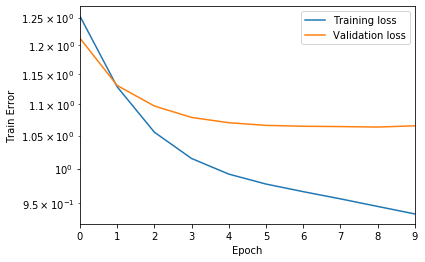

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    pd.Series(history.history['loss']).plot(logy=True, label='Training loss')
    pd.Series(history.history['val_loss']).plot(logy=True, label='Validation loss')
    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Train Error")
    plt.show()
    
plot_history(history)

### Evaluate on test dataset and compute RMSE

In [15]:
from sklearn.metrics import mean_absolute_error

predicted_rates_test = model.predict([user_index_test, item_index_test])

err_test = mean_absolute_error(rates_test, predicted_rates_test)

print("Mean absolute error on the test set: {}".format(err_test))

Mean absolute error on the test set: 0.755960480432236


### Design a simple baseline:  predict average rate per item and recommend items with the highest rating

In [16]:
gbo = df_test[["item", "rate"]].groupby("item").mean().reset_index()
df_gbo = pd.merge(df_test, gbo, on="item", suffixes=('', '_gbo'))
predicted_rates_gbo_test = df_gbo.rate_gbo.values

err_gbo_test = mean_absolute_error(rates_test + mean_rating_test, predicted_rates_gbo_test)
print("Mean absolute error on the test set: {}".format(err_gbo_test))

Mean absolute error on the test set: 1.001301090559222


### Generate recommendations from this baseline

In [17]:
def recommend_highest_rates(df, userList, nrRecommendations=10):
    gbo_set = {}
    
    # compute mean rating per item
    all_items = numpy.unique(df['item'].values)
    gbos = df.groupby("item").mean().rate.reset_index().sort_values(by="rate", ascending=False).item.values[:nrRecommendations]
    
    for user in userList:
        gbo_set[user] = gbos
            
    return gbo_set

### Run evaluation for some users

In [18]:
# example
nr_sampled_users = 10

for index in numpy.random.choice(range(num_users), size=nr_sampled_users):
    u, p, r = df[['user', 'item', 'rate']].values[index]
    learnt_product_embedding = model.get_layer(name='Item-Embedding').get_weights()[0]
    learnt_user_embedding = model.get_layer(name='User-Embedding').get_weights()[0]

    predicted_rates = numpy.dot(learnt_user_embedding, learnt_product_embedding.T)

    rhat = tf.gather(tf.gather(tf.add(predicted_rates, mean_rating), u-1), p-1)
    print ("rating for user " + str(u) + " for item " + str(p) + " is " + str(r) + " and our prediction is: " + str(rhat.numpy()))


rating for user 138 for item 484 is 4 and our prediction is: 4.2640038
rating for user 208 for item 216 is 5 and our prediction is: 3.8040414
rating for user 191 for item 751 is 3 and our prediction is: 3.437961
rating for user 92 for item 587 is 3 and our prediction is: 3.5363207
rating for user 185 for item 23 is 4 and our prediction is: 4.018039
rating for user 15 for item 25 is 3 and our prediction is: 2.993996
rating for user 92 for item 77 is 3 and our prediction is: 3.0139482
rating for user 94 for item 265 is 4 and our prediction is: 3.6183498
rating for user 275 for item 597 is 3 and our prediction is: 3.1066308
rating for user 215 for item 211 is 4 and our prediction is: 3.9682312


### Define and compute Precision@K score

1) Create validation set for every user

2) Generate recommendations

3) Compute precision@K

### Create validation set for every user

In [19]:
def create_validation_set(df, minRate=3.5):
    validation_set = {}
    
    for user in numpy.unique(df['user'].values):
        rated_items = df[df['user'] == user]['item'].values
        rates = df[df['user'] == user]['rate'].values

        best_ranked_items = rated_items[numpy.where(rates > minRate)[0]]
        if len(best_ranked_items) > 0:
            validation_set[user] = best_ranked_items
            
    return validation_set


### Generate recommendations from the trained model for a list of users

In [20]:
def create_recommendations(model, user_index, item_index, listOfUsers, nrRecommendations=20):
    
    predicted_rates = model.predict([user_index, item_index]) 
    
    user_index = numpy.array(user_index)
    item_index = numpy.array(item_index)
    
    recommendations_set = {}
    
    for user in listOfUsers:
        # get rows of the users
        rows = numpy.where(user_index == user)[0]
        # get items and rates
        items = item_index[rows]
        rates = predicted_rates[rows]
        
        if len(rates) > 1:
            ranked_items_idx = numpy.argsort(rates, axis=0)[::-1].squeeze()
            ranked_items = items[ranked_items_idx]
        else:
            ranked_items = items

        recommendations_set[user] = ranked_items[:nrRecommendations]
        
    return recommendations_set

### Compute precision@k using the recommendations and the validation set

In [21]:
def compute_precisionAtK(validations_set, recommendations_set, k=3):

    precisionAtK = []
    for user in validations_set.keys():

        precisionAtK.append(tf.keras.metrics.top_k_categorical_accuracy(
        validations_set[user][numpy.newaxis],
        recommendations_set[user][numpy.newaxis],
        k=k
    ).numpy())

    return numpy.mean(precisionAtK)

In [23]:
validation_set = create_validation_set(df_test, minRate=3.5)
recommendations_set = create_recommendations(model, user_index_test, item_index_test, \
                                              validation_set.keys(), nrRecommendations=20)
highest_rates_baseline = recommend_highest_rates(df, validation_set.keys(), nrRecommendations=20)

precision = compute_precisionAtK(validation_set, recommendations_set, k=10)
precision_baseline = compute_precisionAtK(validation_set, highest_rates_baseline, k=10)
print("Baseline: Precision@{} is {}".format(10, precision_baseline))
print("MF: Precision@{} is {}".format(10, precision))



Baseline: Precision@10 is 0.4720430076122284
MF: Precision@10 is 0.4333333373069763


### Add the results from MF and the baseline into the result table

In [24]:
table.add(name="gbo", rmse=err_gbo_test, precision=precision_baseline)
table.add(name="MF", rmse=err_test, precision=precision)
table.show()


,name,RMSE,Precision@10
0,gbo,1.001301,0.472043
1,MF,0.755960,0.433333


### Q4: Benchmark several experiments with different hyperparameters and put the in the results table 

In [25]:
#table.add(name="experiment_l1regularization", rmse=err_test, precision=precision)
table.show()

,name,RMSE,Precision@10
0,gbo,1.001301,0.472043
1,MF,0.755960,0.433333


# Neural networks for recommendation
Create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

- Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
- We can now have a different dimension of user and item embeddings. This can be useful if one dimension is larger than the other.

In [26]:
n_latent_factors_user = 5
n_latent_factors_item = 8

item_input = tf.keras.layers.Input(shape=[1],name='Item')
item_embedding = tf.keras.layers.Embedding(num_items + 1, n_latent_factors_item, name='Item-Embedding')(item_input)
item_vec = tf.keras.layers.Flatten(name='FlattenItems')(item_embedding)
item_vec = tf.keras.layers.Dropout(0.2)(item_vec)

user_input = tf.keras.layers.Input(shape=[1],name='User')
user_embedding = tf.keras.layers.Embedding(num_users + 1, n_latent_factors_user,name='User-Embedding')(user_input)
user_vec = tf.keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec = tf.keras.layers.Dropout(0.2)(user_vec)

concat = tf.keras.layers.concatenate([item_vec, user_vec], name='Concat')
concat_dropout = tf.keras.layers.Dropout(0.2)(concat)
dense = tf.keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = tf.keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = tf.keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = tf.keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = tf.keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 =tf.keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = tf.keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

result = tf.keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

adam = optimizer = tf.optimizers.Adam( lr=0.0001)
model_NN = tf.keras.Model([user_input, item_input], result)
model_NN.compile(optimizer=adam,loss= 'mean_absolute_error')
model_NN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
____________________________________________________________________________________________

In [27]:
numberEpochs = 20
print_log = 0
history_NN = model_NN.fit([user_index, item_index], rates, epochs=numberEpochs, verbose=print_log, validation_split=0.1)

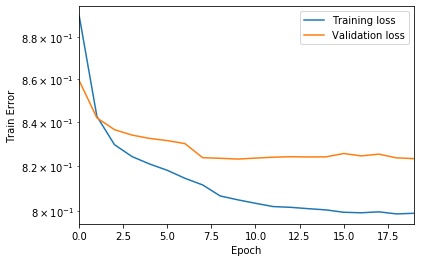

In [28]:
plot_history(history_NN)

In [29]:
from sklearn.metrics import mean_absolute_error

predicted_rates_train = model_NN.predict([user_index, item_index])
err_train = mean_absolute_error(rates, predicted_rates_train)

print("Mean absolute error on the train set: {}".format(err_train))


predicted_rates_test = model_NN.predict([user_index_test, item_index_test])
err_test_NN = mean_absolute_error(rates_test, predicted_rates_test)

print("Mean absolute error on the test set: {}".format(err_test_NN))

Mean absolute error on the train set: 0.7908699312648444
Mean absolute error on the test set: 0.8154695542947913


### Precision@K

In [30]:
recommendations_set_NN = create_recommendations(model_NN, user_index_test, item_index_test, \
                                             validation_set.keys(), nrRecommendations=20)

precision_NN = compute_precisionAtK(validation_set, recommendations_set_NN, k=10)
print("Baseline: Precision@{} is {}".format(10, precision_baseline))
print("Precision@{} is {}".format(10, precision_NN))
print("MF: Precision@{} is {}".format(10, precision))


Baseline: Precision@10 is 0.4720430076122284
Precision@10 is 0.4677419364452362
MF: Precision@10 is 0.4333333373069763


In [31]:
table.add(name="NNMF", rmse=err_test_NN, precision=precision_NN)
table.show()

,name,RMSE,Precision@10
0,gbo,1.001301,0.472043
1,MF,0.755960,0.433333
2,NNMF,0.815470,0.467742


### Final scores

In [32]:
display(table.table.sort_values(by="RMSE"))


,name,RMSE,Precision@10
1,MF,0.755960,0.433333
2,NNMF,0.815470,0.467742
0,gbo,1.001301,0.472043


In [33]:
display(table.table.sort_values(by="Precision@10", ascending=False))

,name,RMSE,Precision@10
0,gbo,1.001301,0.472043
2,NNMF,0.815470,0.467742
1,MF,0.755960,0.433333
